In [1]:
from functools import reduce
from typing import List

import datasets
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Util functions

In [3]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [4]:
def compute_clm_loss(logits, labels):
    # Classical Language modeling task (nope)
    # Next token prediction task in causual setup
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1), ignore_index=-100)
    return loss

In [5]:
def compute_shifted_cossim_loss(input_logits, output_logits):
    # Classical Language modeling task (nope)
    # Next token prediction task in causual setup
    shift_input = input_logits[..., :-1, :].contiguous()
    shift_output = output_logits[..., 1:, :].contiguous()
    loss = (1 - F.cosine_similarity(shift_input, shift_output, -1)).mean()
    return loss

## Using daily_dialog dataset
This dataset contains emotions and acts, each dialog is a separate list of lines

In [7]:
dd_dataset = datasets.load_dataset('daily_dialog')
dd_dataset

Found cached dataset daily_dialog (/home/hivaze/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 11118
    })
    validation: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
})

In [8]:
dd_dataset['train'][:3]

{'dialog': [['Say , Jim , how about going for a few beers after dinner ? ',
   ' You know that is tempting but is really not good for our fitness . ',
   ' What do you mean ? It will help us to relax . ',
   " Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? ",
   " I guess you are right.But what shall we do ? I don't feel like sitting at home . ",
   ' I suggest a walk over to the gym where we can play singsong and meet some of our friends . ',
   " That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . ",
   ' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . ',
   " Good.Let ' s go now . ",
   ' All right . '],
  ['Can you do push-ups ? ',
   " Of course I can . It's a piece of cake ! Believe it or not , I can do 30 push-ups a minute . ",
   " Really ? I think that's impossible ! ",
   ' You mean 30

In [9]:
reduce(lambda x, y: set(x) | set(y), dd_dataset['train']['emotion'])

{0, 1, 2, 3, 4, 5, 6}

In [10]:
reduce(lambda x, y: set(x) | set(y), dd_dataset['train']['act'])

{1, 2, 3, 4}

(array([3.791e+03, 3.057e+03, 2.119e+03, 1.669e+03, 3.110e+02, 1.090e+02,
        4.000e+01, 1.100e+01, 8.000e+00, 3.000e+00]),
 array([ 2. ,  5.3,  8.6, 11.9, 15.2, 18.5, 21.8, 25.1, 28.4, 31.7, 35. ]),
 <BarContainer object of 10 artists>)

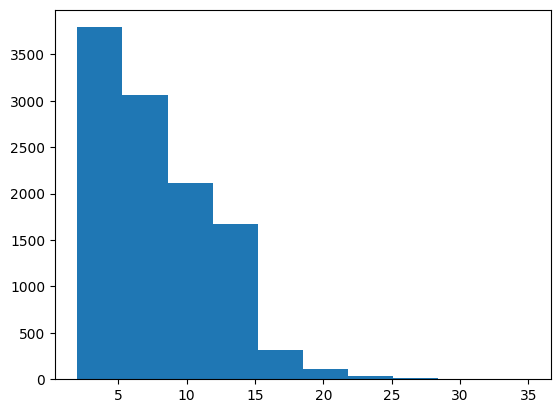

In [11]:
dialogs_lengths = [len(x) for x in dd_dataset['train']['dialog']]
plt.hist(dialogs_lengths)

## Phrase encoder model

In [12]:
# phrase_model = 'roberta-base'
# phrase_model = 'microsoft/deberta-v3-base'
# phrase_model = 'sentence-transformers/all-MiniLM-L12-v2'
# phrase_model = 'sentence-transformers/bert-base-nli-mean-tokens'
phrase_model = 'intfloat/e5-base'
# phrase_model = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'
# phrase_model = 'sentence-transformers/paraphrase-mpnet-base-v2'
# phrase_model = 'sentence-transformers/sentence-t5-base'
# tokenizer = AutoTokenizer.from_pretrained(phrase_model)
# model = AutoModel.from_pretrained(phrase_model).to(device)
# model
sent_transformer = SentenceTransformer(model_name_or_path=phrase_model, device=device)
sent_transformer

No sentence-transformers model found with name /home/hivaze/.cache/torch/sentence_transformers/intfloat_e5-base. Creating a new one with MEAN pooling.


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [13]:
sent_transformer.max_seq_length = 256
sent_transformer

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [14]:
test_phrases = ['Some day i will go to school',
                'To make maximum progress on addressing these pressing problems',
                'I will nether go to school',
                'I like to visit school',
                'THe day will come when i will go to school']

phrases_encodings = sent_transformer.encode(test_phrases, convert_to_tensor=True, normalize_embeddings=True)
phrases_encodings.shape

torch.Size([5, 768])

In [15]:
F.cosine_similarity(phrases_encodings[0], phrases_encodings[1:])

tensor([0.7232, 0.8850, 0.8622, 0.9491], device='cuda:0')

In [16]:
torch.cdist(phrases_encodings, phrases_encodings)

tensor([[0.0000, 0.7441, 0.4796, 0.5250, 0.3190],
        [0.7441, 0.0000, 0.7644, 0.7989, 0.7910],
        [0.4796, 0.7644, 0.0000, 0.5644, 0.4903],
        [0.5250, 0.7989, 0.5644, 0.0000, 0.5372],
        [0.3190, 0.7910, 0.4903, 0.5372, 0.0000]], device='cuda:0')

## Dialog encoder model

Концептуально тут нужно:
- модель-кодировщик фраз (замоороженная) -> готовые эмбединги текста
- эмбединги участников диалога
- эмбединги позиции текста в диалоге
- кастомный токенизер c BOS и EOS
- causual lm crossentropy loss
- causual маска атеншена
- финальный классификатор в условный словарь

In [17]:
class DialogEmbeddings(nn.Module):
    def __init__(self, encoder_hidden_dim: int,
                 max_interlocutors_count: int,
                 max_dialogue_length: int,
                 dropout_p: float):
        super(DialogEmbeddings, self).__init__()

        self.padding_idx = 0  # special index for padding (must be in tokenizer)

        self.position_embeddings = nn.Embedding(max_dialogue_length + 1,  # padding
                                                encoder_hidden_dim, padding_idx=self.padding_idx)
        self.interlocutors_embeddings = nn.Embedding(max_interlocutors_count + 2,  # padding + bos
                                                     encoder_hidden_dim, padding_idx=self.padding_idx)
        self.norm = nn.LayerNorm(encoder_hidden_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, interlocutors_ids: torch.LongTensor, position_ids: torch.LongTensor = None):
        if position_ids is None:
            position_ids = self.create_position_ids_from_input_ids(interlocutors_ids)

        interlocutors_embeds = self.interlocutors_embeddings(interlocutors_ids)
        position_embeds = self.position_embeddings(position_ids)

        embeddings = interlocutors_embeds + position_embeds
        embeddings = self.norm(embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings

    def create_position_ids_from_input_ids(self, input_ids):
        """
        Replace non-padding symbols with their position numbers. Position numbers begin at padding_idx+1. Padding symbols
        are ignored. This is modified from fairseq's `utils.make_positions`. :param torch.Tensor x: :return torch.Tensor:
        """
        # The series of casts and type-conversions here are carefully balanced to both work with ONNX export and XLA.
        mask = input_ids.ne(self.padding_idx).int()
        incremental_indices = torch.cumsum(mask, dim=1).type_as(mask) * mask
        return incremental_indices.long() + self.padding_idx

In [35]:
class DialogTransformer(nn.Module):
    def __init__(self, encoder_hidden_dim: int,
                 out_vocab_size: int,
                 max_dialogue_length: int,
                 max_interlocutors_count: int,
                 decoder_n_layers: int = 1,
                 decoder_n_head: int = 4,
                 dim_feedforward_mult: int = 3,
                 dropout_p: float = 0.1):
        super(DialogTransformer, self).__init__()

        self.norm = nn.LayerNorm(encoder_hidden_dim)
        self.eos_vector = nn.Parameter(torch.randn([encoder_hidden_dim]), requires_grad=True)
        self.dialogue_embeddings = DialogEmbeddings(encoder_hidden_dim, max_interlocutors_count,
                                                    max_dialogue_length, dropout_p)

        decoder_ff_inner_dim = encoder_hidden_dim * dim_feedforward_mult
        layer = nn.TransformerEncoderLayer(d_model=encoder_hidden_dim,
                                           nhead=decoder_n_head,
                                           dim_feedforward=decoder_ff_inner_dim,
                                           activation=F.gelu,  # using gelu instead of default relu
                                           dropout=dropout_p,
                                           batch_first=True)  # using encoder layers due to not a seq2seq setup
        self.model = nn.TransformerEncoder(layer, decoder_n_layers)

        self.labels_projector = nn.Linear(in_features=encoder_hidden_dim, out_features=out_vocab_size, bias=True)
        self.interlocutors_projector = nn.Linear(in_features=encoder_hidden_dim, out_features=max_interlocutors_count, bias=True)

    def forward(self, encodings: torch.FloatTensor,
                interlocutors_ids: torch.LongTensor,
                position_ids: torch.LongTensor = None,
                attention_mask: torch.BoolTensor = None,
                labels: torch.LongTensor = None):
        """
        :param encodings: Pooled hiddens from sentence-transformer in shape [bs, lines_count, hidden_dim]
        :param labels: Labels for dialog lines
        :param interlocutors_ids: shape [bs, seq_len], interlocutors for each line (from one)
        :param position_ids: shape [bs, seq_len], position of line in dialogue (from one)
        :param attention_mask: shape [bs, seq_len], attention mask for padding where 1 is disabled and 0 is enabled
        """

        batch_size = encodings.shape[0]

        x = self.norm(encodings)

        representation = torch.cat([
            x,
            self.eos_vector.repeat([batch_size, 1, 1]),
        ], dim=1)  # insert bos vector

        x = representation + self.dialogue_embeddings(interlocutors_ids=interlocutors_ids, position_ids=position_ids)

        causal_mask = torch.triu(torch.ones(x.shape[1], x.shape[1]), diagonal=1).bool().to(
            x.device)  # only attend to past (not necessary, but logical...)
        x = self.model.forward(src=x, mask=causal_mask, src_key_padding_mask=attention_mask)

        predicted_labels = self.labels_projector(x)
        predicted_interlocutors = self.interlocutors_projector(x)

        if labels is not None:
            copied_interlocutors = interlocutors_ids.clone() - 2
            copied_interlocutors[copied_interlocutors < 0] = -100

            interlocutors_loss = compute_clm_loss(predicted_interlocutors, copied_interlocutors)
            logits_loss = compute_shifted_cossim_loss(x, representation)

            total_loss = logits_loss + interlocutors_loss

            return total_loss, predicted_labels, predicted_interlocutors

        # if labels is not None:
        #     labels_loss = compute_clm_loss(predicted_labels, labels)
        #
        #     copied_interlocutors = interlocutors_ids.clone() - 2
        #     copied_interlocutors[copied_interlocutors < 0] = -100
        #     interlocutors_loss = compute_clm_loss(predicted_interlocutors, copied_interlocutors)
        #
        #     total_loss = labels_loss + interlocutors_loss
        #
        #     return total_loss, predicted_labels, predicted_interlocutors

        return predicted_labels, predicted_interlocutors

In [36]:
torch.triu(torch.ones(10, 10), diagonal=1).bool()

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False, False, False]])

In [37]:
dialo_transformer = DialogTransformer(encoder_hidden_dim=768,
                                      out_vocab_size=7,
                                      max_dialogue_length=50,
                                      max_interlocutors_count=2,
                                      decoder_n_layers=6,
                                      decoder_n_head=8,
                                      dim_feedforward_mult=4,
                                      dropout_p=0.1
                                      ).to(sent_transformer.device).eval()
dialo_transformer

DialogTransformer(
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dialogue_embeddings): DialogEmbeddings(
    (position_embeddings): Embedding(51, 768, padding_idx=0)
    (interlocutors_embeddings): Embedding(4, 768, padding_idx=0)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (model): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
  

In [39]:
summary(dialo_transformer)

Layer (type:depth-idx)                                            Param #
DialogTransformer                                                 768
├─LayerNorm: 1-1                                                  1,536
├─DialogEmbeddings: 1-2                                           --
│    └─Embedding: 2-1                                             39,168
│    └─Embedding: 2-2                                             3,072
│    └─LayerNorm: 2-3                                             1,536
│    └─Dropout: 2-4                                               --
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-5                                            --
│    │    └─TransformerEncoderLayer: 3-1                          7,087,872
│    │    └─TransformerEncoderLayer: 3-2                          7,087,872
│    │    └─TransformerEncoderLayer: 3-3                          7,087,872
│    │    └─TransformerEncoderLayer: 3-4                       

In [40]:
class DialogTokenizer:
    """
    Accepts dicts with keys: 'dialog' - required, 'interlocutors' and 'labels'
    Must return dict with 'encoder_hidden', 'interlocutors_ids' and 'labels'
    """

    def __init__(self, lines_encoder: SentenceTransformer,
                 all_labels: list = None,
                 all_interlocutors: list = None):

        self.lines_encoder = lines_encoder

        self.padding_idx = 0
        self.eos_idx = 1

        if all_labels:
            all_labels = set(all_labels)
            self.id2label = dict(zip(range(len(all_labels)), all_labels))
            self.label2id = {v: k for k, v in self.id2label.items()}
        if all_interlocutors:
            all_interlocutors = set(all_interlocutors)
            self.id2interlocutors = dict(zip(range(2, len(all_interlocutors) + 2), all_interlocutors))
            self.interlocutor2id = {v: k for k, v in self.id2label.items()}

    def encode(self, dialog: List[str],
               interlocutors: List[int] = None,
               labels: List[int] = None,
               lines_batch_size=32,
               unsqueeze=True):

        encodings = self.lines_encoder.encode(sentences=dialog,
                                              batch_size=lines_batch_size,
                                              normalize_embeddings=True,
                                              show_progress_bar=False,
                                              convert_to_tensor=True)
        encodings.requires_grad = False

        if interlocutors is None:
            interlocutors = [(i % 2) + 2 for i in range(len(dialog))]
        elif hasattr(self, 'interlocutor2id'):
            interlocutors = list(map(self.interlocutor2id.get, interlocutors))
        if labels is not None and hasattr(self, 'label2id'):
            labels = list(map(self.label2id.get, labels))

        interlocutors = interlocutors + [self.eos_idx]
        if labels is not None:
            labels = labels + [-100]

        result = {
            'encodings': encodings.unsqueeze(0) if unsqueeze else encodings,
            'interlocutors_ids': torch.LongTensor([interlocutors] if unsqueeze else interlocutors).to(encodings.device)
        }
        if labels is not None:
            result['labels'] = torch.LongTensor([labels] if unsqueeze else labels).to(encodings.device)

        return result

    def encode_batch(self, dialog: List[List[str]],
                     interlocutors: List[List[int]] = None,
                     labels: List[List[int]] = None,
                     lines_batch_size=50):

        if interlocutors is None:
            interlocutors = [None] * len(dialog)
        if labels is None:
            labels = [None] * len(dialog)
        unsqueeze = [False] * len(dialog)

        assert len(dialog) == len(interlocutors) and len(interlocutors) == len(labels)

        zipped = zip(dialog, interlocutors, labels, [lines_batch_size] * len(dialog), unsqueeze)
        encoded_batch = list(map(lambda x: self.encode(*x), zipped))

        encodings = pad_sequence([encode_dict['encodings'] for encode_dict in encoded_batch],
                                 batch_first=True,
                                 padding_value=self.padding_idx)
        encodings.requires_grad = False

        interlocutors_ids = pad_sequence([encode_dict['interlocutors_ids'] for encode_dict in encoded_batch],
                                         batch_first=True,
                                         padding_value=self.padding_idx)

        lengths = [len(dial) + 1 for dial in dialog]  # keep in mind bos vector
        masks = list(map(lambda x: torch.zeros(size=[x]), lengths))
        attention_masks = pad_sequence(masks, batch_first=True, padding_value=1).bool().to(encodings.device)

        result = {
            'encodings': encodings,
            'interlocutors_ids': interlocutors_ids,
            'attention_mask': attention_masks
        }
        if labels[0] is not None:
            labels = pad_sequence([encode_dict['labels'] for encode_dict in encoded_batch],
                                  batch_first=True,
                                  padding_value=-100)
            result['labels'] = labels

        return result

In [41]:
dialo_tokenizer = DialogTokenizer(sent_transformer,
                                  # all_labels=[1, 2, 3, 4]
                                  )

In [42]:
dialo_encoded = dialo_tokenizer.encode(['Hello man', 'Goodbye', 'Thanks'],
                                       labels=[1, 3, 1])
dialo_encoded

{'encodings': tensor([[[-0.0042,  0.0217, -0.0237,  ...,  0.0116,  0.0340,  0.0314],
          [-0.0369,  0.0174,  0.0452,  ...,  0.0200,  0.0160,  0.0653],
          [-0.0401,  0.0212, -0.0176,  ...,  0.0143,  0.0121,  0.0441]]],
        device='cuda:0'),
 'interlocutors_ids': tensor([[2, 3, 2, 1]], device='cuda:0'),
 'labels': tensor([[   1,    3,    1, -100]], device='cuda:0')}

In [43]:
dialo_transformer.forward(**dialo_encoded)

(tensor(1.7481, device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[-0.7042, -0.7361,  0.6979, -0.4645,  0.9864,  0.1224, -1.1395],
          [-0.2058, -0.3343,  0.1103, -0.3265,  0.9724,  0.2944, -1.0671],
          [-0.6186, -0.5042,  0.4554, -0.0337,  0.6771,  0.1185, -1.2657],
          [-0.6287, -0.9157,  0.1138, -0.0457,  1.4048, -0.0072, -0.6282]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 tensor([[[ 0.3196, -0.3407],
          [ 0.2296, -0.1094],
          [ 0.3050, -0.1324],
          [ 1.1594,  0.1484]]], device='cuda:0', grad_fn=<ViewBackward0>))

In [44]:
dialogs_encoded = dialo_tokenizer.encode_batch(dialog=[
    ['Hello', 'Hi there', 'Goodbye'], ['My name is', 'Stop', 'Go away', 'Please']
], labels=[
    [1, 1, 3], [2, 3, 1, 2]
])
dialogs_encoded

{'encodings': tensor([[[-0.0222,  0.0347, -0.0330,  ...,  0.0192,  0.0224,  0.0413],
          [-0.0181,  0.0499, -0.0205,  ...,  0.0387,  0.0148,  0.0444],
          [-0.0369,  0.0174,  0.0452,  ...,  0.0200,  0.0160,  0.0653],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.0155,  0.0169, -0.0177,  ...,  0.0393,  0.0083,  0.0618],
          [-0.0271,  0.0169, -0.0272,  ...,  0.0270,  0.0196,  0.0157],
          [-0.0341,  0.0635, -0.0151,  ...,  0.0327,  0.0089,  0.0714],
          [-0.0260,  0.0257, -0.0143,  ...,  0.0143,  0.0018,  0.0442]]],
        device='cuda:0'),
 'interlocutors_ids': tensor([[2, 3, 2, 1, 0],
         [2, 3, 2, 3, 1]], device='cuda:0'),
 'attention_mask': tensor([[False, False, False, False,  True],
         [False, False, False, False, False]], device='cuda:0'),
 'labels': tensor([[   1,    1,    3, -100, -100],
         [   2,    3,    1,    2, -100]], device='cuda:0')}

In [45]:
dialo_transformer.forward(**dialogs_encoded)

(tensor(1.7404, device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[-0.7095, -0.6706,  0.3404, -0.5564,  0.8437,  0.2011, -1.1407],
          [-0.0254, -0.2928, -0.1531, -0.5913,  0.8622,  0.2891, -1.2287],
          [-0.5786, -0.5341, -0.0941, -0.2266,  0.7673,  0.1787, -0.9681],
          [-0.3354, -0.7799,  0.1171, -0.2230,  1.3337,  0.1878, -0.7180],
          [-0.6826, -0.8465,  0.1663, -0.0961,  1.1494,  0.2328, -0.8802]],
 
         [[-0.2975, -0.8617,  0.4696, -0.1252,  0.9753,  0.5724, -1.3509],
          [ 0.1282, -0.2586,  0.2773, -0.3133,  1.0429,  0.5871, -1.3603],
          [-0.2562, -0.3986,  0.1804, -0.2978,  0.7214,  0.6200, -1.3813],
          [-0.0725, -0.4585,  0.2548,  0.2197,  1.0482,  0.7793, -1.4150],
          [-0.2234, -0.6633,  0.2036, -0.0663,  1.1244,  0.5459, -1.1681]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 tensor([[[ 0.3441, -0.3382],
          [ 0.2490, -0.0729],
          [ 0.1897, -0.2438],
          [ 0.7562, -0.3090],
          [ 1.04

## Training

In [46]:
# Accepts list of dialog dicts per batch
def collate_batch(batch: list):
    v = {k: [dic[k] for dic in batch] for k in batch[0].keys()}  # list of dicts to dict of lists
    return v

In [47]:
dd_dataset['train'] = dd_dataset['train'].rename_column('emotion', 'labels').remove_columns(['act'])
dd_dataset['validation'] = dd_dataset['validation'].rename_column('emotion', 'labels').remove_columns(['act'])
dd_dataset['test'] = dd_dataset['test'].rename_column('emotion', 'labels').remove_columns(['act'])
dd_dataset

ValueError: Original column name emotion not in the dataset. Current columns in the dataset: ['dialog', 'labels']

In [48]:
train_dataloader = DataLoader(dd_dataset['train'], collate_fn=collate_batch, shuffle=True, batch_size=128)
eval_dataloader = DataLoader(dd_dataset['validation'], collate_fn=collate_batch, shuffle=True, batch_size=256)

In [49]:
from torch.optim import AdamW
from transformers import get_scheduler

In [50]:
optimizer = AdamW(dialo_transformer.parameters(), lr=5e-5)

In [51]:
num_epochs = 6
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=10,
                             num_training_steps=num_training_steps)

In [52]:
def evaluate(model: DialogTransformer, tokenizer: DialogTokenizer):
    model.eval()
    losses = []
    for batch in tqdm(eval_dataloader):
        with torch.inference_mode():
            tokenized_input = tokenizer.encode_batch(**batch)
            loss, l, i = dialo_transformer.forward(**tokenized_input)
            del l, i
        losses.append(loss.detach().item())
    return losses

In [53]:
evaluate(dialo_transformer, dialo_tokenizer)

  0%|          | 0/4 [00:00<?, ?it/s]

[1.7392239570617676, 1.7405672073364258, 1.738313913345337, 1.7393399477005005]

In [54]:
def train(model: DialogTransformer, tokenizer: DialogTokenizer):
    progress_bar = tqdm(range(num_training_steps))
    for epoch in range(num_epochs):
        model.train()
        print(f'Starting epoch {epoch}...')
        train_losses = []

        for batch in train_dataloader:
            tokenized_input = tokenizer.encode_batch(**batch)
            loss, l, i = dialo_transformer.forward(**tokenized_input)
            loss.backward()

            train_losses.append(loss.item())

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

            del l, i

        eval_losses = evaluate(dialo_transformer, dialo_tokenizer)

        print(f'Mean train loss: {np.array(train_losses).mean()}')
        print(f'Mean eval loss: {np.array(eval_losses).mean()}')

In [55]:
train(dialo_transformer, dialo_tokenizer)

  0%|          | 0/522 [00:00<?, ?it/s]

Starting epoch 0...


  0%|          | 0/4 [00:00<?, ?it/s]

Mean train loss: 0.34102522247824174
Mean eval loss: 0.12985403463244438
Starting epoch 1...


  0%|          | 0/4 [00:00<?, ?it/s]

Mean train loss: 0.16332982771698085
Mean eval loss: 0.1217700932174921
Starting epoch 2...


  0%|          | 0/4 [00:00<?, ?it/s]

Mean train loss: 0.1581036620612802
Mean eval loss: 0.1365481335669756
Starting epoch 3...


  0%|          | 0/4 [00:00<?, ?it/s]

Mean train loss: 0.15589607387096033
Mean eval loss: 0.11642501689493656
Starting epoch 4...



KeyboardInterrupt



## Tests

In [ ]:
test_encoded = dialo_tokenizer.encode(['Congratulations , Vivian . You won the grand prize , again .',
                                       "Isn't it just great ! I just knew I'd win !",
                                       "You did ? How ? Did you wear red underwear again this year ?",
                                       "Not only that !",
                                       'Okey, its not interesting, go away from me'])
test_encoded

In [ ]:
with torch.inference_mode():
    test_output = dialo_transformer.forward(**test_encoded)
test_output

In [ ]:
test_output[1].softmax(-1).argmax(-1)

In [ ]:
test_output[0].softmax(-1).argmax(-1)